In [1]:
from minimal_model import ref_parameters, perturbation_dynamics, perturbation_steady_state, I0
import numpy as np



In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']



In [3]:
# Scaling 

# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 


In [4]:
KI_F = 0.2
p_fited = ref_parameters( KI_F = KI_F)

In [5]:
# Compare the predictions to mice data of outbred mice colony
data = pd.read_table('data/BXD_metabolic_traits.tsv', index_col=0, sep='\t') 


# Normalize the data to the base line fat mass
# drop al columns that end on _SE 
data = data.drop(columns=[c for c in data.columns if c.endswith('_SE')])
# Replxa x with nan
data = data.replace('x', np.nan)

# Find data columns i.e all colums after C57BL/6J
data_columns = data.columns[data.columns.get_loc('C57BL/6J'):]

# Convert type of data columns to float
data[data_columns] = data[data_columns].astype(float)

# Average data
data_averaged = data.groupby(['Trait','Diet'])[data_columns].median().reset_index()

# Melt data 
data_averaged_melt = data_averaged.melt(id_vars=['Trait','Diet'], var_name='Strain', value_name='Value')
# Pivot to Trait as columns
data_averaged_pivot = data_averaged_melt.pivot_table(index=['Strain','Diet'], columns='Trait', values='Value').reset_index()


# Normalize to the baseline fat mass
data_averaged_pivot['Fat mass [rel]'] = data_averaged_pivot['Fat mass [g]'] / 3.6 # C57BL/6J baseline fat mass


In [6]:
data_averaged_pivot[ data_averaged_pivot.Strain.isin(['C57BL/6J', 'DBA/2J']) ]


Trait,Strain,Diet,Fat mass [g],Glucose [mg/dl],Insulin [ng/ml],Fat mass [rel]
115,C57BL/6J,CD,3.790000,109.666672,0.38700,1.052778
116,C57BL/6J,HFD,13.657250,163.000000,3.30000,3.793681
117,DBA/2J,CD,8.098125,91.893001,2.72175,2.249479
118,DBA/2J,HFD,16.602275,132.699997,3.78550,4.611743


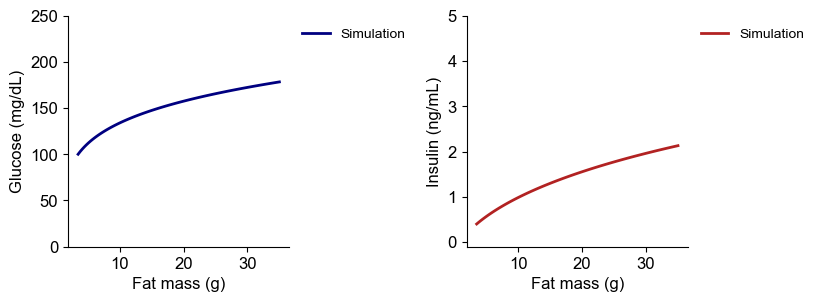

In [7]:
# Get steady state of Insulin and Glucose for increased adipose 
from adjustText import adjust_text

A = np.linspace(1, 10, 100)

results = [perturbation_steady_state(a, p=p_fited) for a in A]

# Main Figure insulin and glucose
G = [r[1] for r in results]
I = [r[-1] for r in results]

# Compare to hyperplasicly increased adipose
p_hyper = p_fited.copy()
p_hyper[-1] = True
results_hyperplasia = [perturbation_steady_state(a, p=p_hyper) for a in A]

G_hyper = [r[1] for r in results_hyperplasia]
I_hyper = [r[-1] for r in results_hyperplasia]


# Supplementary Figure the rest 
L = [r[0] for r in results]
K = [r[2] for r in results]
F = [r[3] for r in results]

# Plot Glucose and Insulin
f, ax = plt.subplots(1, 2, figsize=(8, 3))
# Increase marign between subplots
plt.subplots_adjust(wspace=0.8)

# Glucose scaled to reference of 100
ax[0].plot(A * 3.5 , np.array(G)* 100, color='navy', label='Simulation', linewidth=2)
#sns.scatterplot(data = data_averaged_pivot, x='Fat mass [g]', y='Glucose [mg/dl]', hue='Diet', ax=ax[0], palette=['darkgrey','tan'], s=20)
#sns.regplot(data = data_averaged_pivot, x='Fat mass [rel]', y='Glucose [mg/dl]', ax=ax[0], scatter=False, color='black', robust=True)

# Add text for original strains with 
# original_strains = data_averaged_pivot[ data_averaged_pivot.Strain.isin(['C57BL/6J', 'DBA/2J']) ]
# text = []
# for i, row in original_strains.iterrows():
#     text.append(ax[0].text(row['Fat mass [g]'], row['Glucose [mg/dl]'], row['Strain'], 
#                            fontsize=8, ha='center', va='center'))

# adjust_text(text, x=original_strains['Fat mass [g]'], y=original_strains['Glucose [mg/dl]'], 
#             force_static=(3.0,3.0), force_explode=(3,3),
#             arrowprops=dict(arrowstyle='-', color='black'), ax=ax[0],)

ax[0].set_ylabel('Glucose (mg/dL)')
ax[0].set_xlabel('Fat mass (g)')
ax[0].set_ylim(0, 250)

# Add legend outside of the plot
ax[0].legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Insulin scaled to reference of ng/mL
ax[1].plot(A * 3.5 , np.array(I)/I0 * 0.4 , color='firebrick', label='Simulation', linewidth=2)
#sns.scatterplot(data = data_averaged_pivot, x='Fat mass [g]', y='Insulin [ng/ml]', hue='Diet', ax=ax[1], palette=['darkgrey','tan'], s=20)
ax[1].set_ylabel('Insulin (ng/mL)')
ax[1].set_xlabel('Fat mass (g)')
ax[1].set_ylim(-0.1, 5)


# Add text for original strains with
# original_strains = data_averaged_pivot[ data_averaged_pivot.Strain.isin(['C57BL/6J', 'DBA/2J']) ]
# text = []
# for i, row in original_strains.iterrows():
#     text.append(ax[1].text(row['Fat mass [g]'], row['Insulin [ng/ml]'], 
#                            row['Strain'], fontsize=8, ha='center', va='center'))

# adjust_text(text, x=original_strains['Fat mass [g]'], y=original_strains['Insulin [ng/ml]'],  
#             force_static=(3.0,3.0), force_explode=(3,3),
#             arrowprops=dict(arrowstyle='-', color='black'), ax=ax[1])

# Add legend outside of the plot
ax[1].legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

#plt.savefig('output/obesety_glucose_insulin_mass_action.svg', bbox_inches='tight')

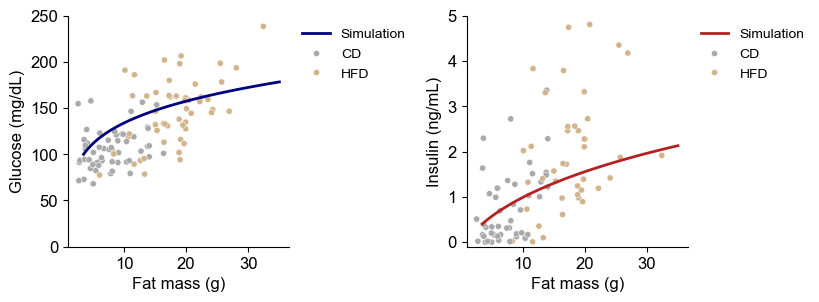

In [8]:
# Get steady state of Insulin and Glucose for increased adipose 
from adjustText import adjust_text

A = np.linspace(1, 10, 100)

results = [perturbation_steady_state(a, p=p_fited) for a in A]

# Main Figure insulin and glucose
G = [r[1] for r in results]
I = [r[-1] for r in results]

# Compare to hyperplasicly increased adipose
p_hyper = p_fited.copy()
p_hyper[-1] = True
results_hyperplasia = [perturbation_steady_state(a, p=p_hyper) for a in A]

G_hyper = [r[1] for r in results_hyperplasia]
I_hyper = [r[-1] for r in results_hyperplasia]


# Supplementary Figure the rest 
L = [r[0] for r in results]
K = [r[2] for r in results]
F = [r[3] for r in results]

# Plot Glucose and Insulin
f, ax = plt.subplots(1, 2, figsize=(8, 3))
# Increase marign between subplots
plt.subplots_adjust(wspace=0.8)

# Glucose scaled to reference of 100
ax[0].plot(A * 3.5 , np.array(G)* 100, color='navy', label='Simulation', linewidth=2)
sns.scatterplot(data = data_averaged_pivot, x='Fat mass [g]', y='Glucose [mg/dl]', hue='Diet', ax=ax[0], palette=['darkgrey','tan'], s=20)
#sns.regplot(data = data_averaged_pivot, x='Fat mass [rel]', y='Glucose [mg/dl]', ax=ax[0], scatter=False, color='black', robust=True)


ax[0].set_ylabel('Glucose (mg/dL)')
ax[0].set_xlabel('Fat mass (g)')
ax[0].set_ylim(0, 250)

# Add legend outside of the plot
ax[0].legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Insulin scaled to reference of ng/mL
ax[1].plot(A * 3.5 , np.array(I)/I0 * 0.4 , color='firebrick', label='Simulation', linewidth=2)
sns.scatterplot(data = data_averaged_pivot, x='Fat mass [g]', y='Insulin [ng/ml]', hue='Diet', ax=ax[1], palette=['darkgrey','tan'], s=20)
ax[1].set_ylabel('Insulin (ng/mL)')
ax[1].set_xlabel('Fat mass (g)')
ax[1].set_ylim(-0.1, 5)


# Add legend outside of the plot
ax[1].legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

plt.savefig('output/obesety_glucose_insulin_mass_action.svg', bbox_inches='tight')

In [9]:
# Make an interpolation function for the glucose and insulin data
from scipy.interpolate import interp1d
# Interpolate the glucose and insulin data
glucose_interp = interp1d(A * 3.5, np.array(G)* 100, fill_value='extrapolate')
insulin_interp = interp1d(A * 3.5, np.array(I)/I0 * 0.4, fill_value='extrapolate')

In [10]:
# Save the mouse data to a file
# Add the differences to simulation data
data_averaged_pivot['Glucose [mg/dl] sim'] = glucose_interp(data_averaged_pivot['Fat mass [g]'])
data_averaged_pivot['Insulin [ng/ml] sim'] = insulin_interp(data_averaged_pivot['Fat mass [g]'])


In [11]:
data_averaged_pivot.to_csv('bdx_genome/BXD_metabolic_traits_averaged.tsv', sep='\t', index=False)

In [56]:
# Copmpute the dynamic with respect to the rest of the variables
vars = ['L','G','K','F','I','IA']
time = np.linspace(0, 10, 100)
X1,F1 = perturbation_dynamics(time, A=1, p=p_fited)
time2 = np.linspace(10+0.01, 180, 100)

X2,F2 = perturbation_dynamics(time2, A=2, p=p_fited, X0=X1.loc[10,vars].values)
# Join the results
X = pd.concat((X1, X2), axis=0)
F = pd.concat((F1, F2), axis=0) 

# Scale the results in X 
X['G'] = X['G'] * 100
X['I'] = X['I'] / I0 * 0.2
X['L'] = X['L'] * 0.75
X['K'] = X['K'] * 0.5
X['F'] = X['F'] * 0.5 

# Scale the results in F but not time
F = F * vATP
F['time'] = F['time']/vATP

# Compute net FA release 
F['vFA'] = F['vA'] - F['vR']

# Compute net gluocse disposal 
F['vGD'] = F['vG'] + F['vGL']

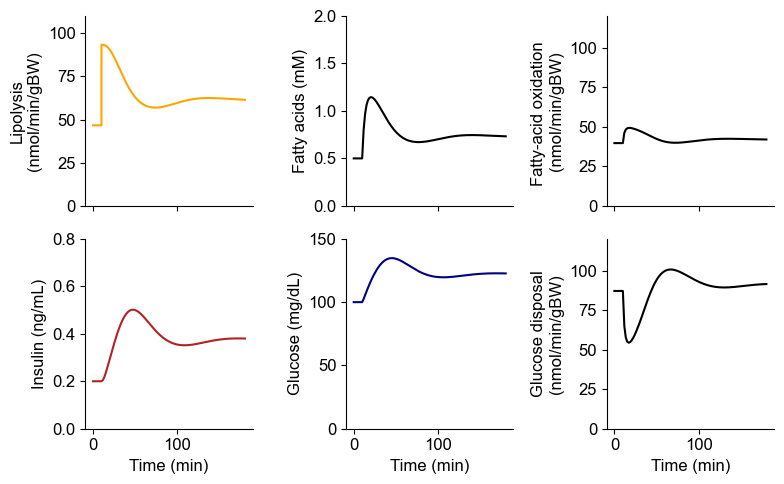

In [60]:
# Make 2 rows 3 columns plot
f, ax = plt.subplots(2, 3, figsize=(8, 5), sharex=True)
# Increease the margin between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# Lipolysis
sns.lineplot(data=F, x='time', y='vA', ax=ax[0, 0], color='orange')

ax[0, 0].set_ylabel('Lipolysis\n(nmol/min/gBW)')
# ylimt
ax[0, 0].set_ylim(0, 110)

# Fatty acid
sns.lineplot(data=X, x='time', y='F', ax=ax[0, 1], color='black')
ax[0, 1].set_ylabel('Fatty acids (mM)')
ax[0, 1].set_xlabel('Time (min)')
# ylimt
ax[0, 1].set_ylim(0, 2.0)

# vF 
sns.lineplot(data=F, x='time', y='vF', ax=ax[0, 2], color='black')
ax[0, 2].set_ylabel('Fatty-acid oxidation \n(nmol/min/gBW)')
# ylimt
ax[0, 2].set_ylim(0, 120)

# vG and vGL
sns.lineplot(data=F, x='time', y='vGD', ax=ax[1, 2], color='black', )
ax[1, 2].set_ylabel('Glucose disposal\n(nmol/min/gBW)')
# Move the legent a bit outside
# ax[1, 2].legend(frameon=False, loc='upper right', bbox_to_anchor=(1.5, 1.1))
ax[1, 2].set_xlabel('Time (min)')
# ylimt
ax[1, 2].set_ylim(0, 120)


# Glucose 
sns.lineplot(data=X, x='time', y='G', ax=ax[1, 1], color='navy')
ax[1, 1].set_ylabel('Glucose (mg/dL)')
ax[1, 1].set_xlabel('Time (min)')
ax[1, 1].set_ylim(0, 150)


# Insulin
sns.lineplot(data=X, x='time', y='I', ax=ax[1, 0], color='firebrick')
ax[1, 0].set_ylabel('Insulin (ng/mL)')
ax[1, 0].set_xlabel('Time (min)')
ax[1, 0].set_ylim(0, 0.8)


plt.tight_layout()
sns.despine()

plt.savefig('output/obesety_dynamics.svg', bbox_inches='tight')


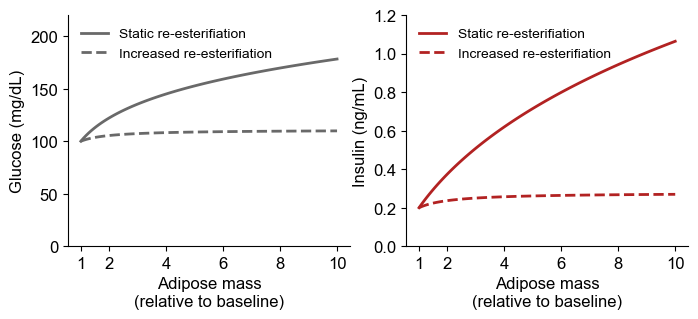

In [61]:
# Get steady state of Insulin and Glucose for increased adipose 

A = np.linspace(1, 10, 100)

results = [perturbation_steady_state(a, p=p_fited) for a in A]

# Main Figure insulin and glucose
G = [r[1] for r in results]
I = [r[-1] for r in results]

# Compare to hyperplasicly increased adipose
p_hyper = p_fited.copy()
p_hyper[-1] = True
results_hyperplasia = [perturbation_steady_state(a, p=p_hyper) for a in A]

G_hyper = [r[1] for r in results_hyperplasia]
I_hyper = [r[-1] for r in results_hyperplasia]


# Supplementary Figure the rest 
L = [r[0] for r in results]
K = [r[2] for r in results]
F = [r[3] for r in results]

# Plot Glucose and Insulin
f, ax = plt.subplots(1, 2, figsize=(8, 3))

# Glucose scaled to reference of 100
ax[0].plot(A, np.array(G)* 100, color='dimgrey', label='Static re-esterifiation', linewidth=2)
ax[0].plot(A, np.array(G_hyper)* 100, color='dimgrey', label='Increased re-esterifiation', linewidth=2, linestyle='--')
ax[0].set_ylabel('Glucose (mg/dL)')
ax[0].set_xlabel('Adipose mass\n(relative to baseline)')
ax[0].set_ylim(0, 220)
ax[0].set_xticks([1, 2, 4,6, 8, 10])
# Add legend
ax[0].legend(frameon=False, fontsize=10)

# Insulin scaled to reference of ng/mL
ax[1].plot(A, np.array(I)/I0 * 0.2 , color='firebrick', label='Static re-esterifiation', linewidth=2)
ax[1].plot(A, np.array(I_hyper)/I0 * 0.2, color='firebrick', label='Increased re-esterifiation', linewidth=2, linestyle='--')
ax[1].set_ylabel('Insulin (ng/mL)')
ax[1].set_xlabel('Adipose mass\n(relative to baseline)')
ax[1].set_ylim(0, 1.2)
ax[1].set_xticks([1, 2, 4,6, 8, 10])

# Add legend
ax[1].legend(frameon=False, fontsize=10)

sns.despine()

plt.savefig('output/obesety_glucose_insulin.svg', bbox_inches='tight')

In [42]:
# Copmpute the dynamic with respect to the rest of the variables
vars = ['L','G','K','F','I',"IA"]
time = np.linspace(0, 10, 100)
X1,F1 = perturbation_dynamics(time, A=1, p=p_fited)
time2 = np.linspace(10+0.01, 180, 100)

X2,F2 = perturbation_dynamics(time2, A=2, p=p_fited, X0=X1.loc[10,vars].values)
# Join the results
X = pd.concat((X1, X2), axis=0)
F = pd.concat((F1, F2), axis=0) 

# Scale the results in X 
X['G'] = X['G'] * 100
X['I'] = X['I'] / I0 * 0.2
X['L'] = X['L'] * 0.75
X['K'] = X['K'] * 0.5

# Scale the results in F but not time
F = F * vATP
F['time'] = F['time']/vATP

# Compute net FA release 
F['vFA'] = F['vA'] - F['vR']

In [43]:
# Copmpute the dynamic with respect to the rest of the variables - for hyperplasic expansion
p_hyper = p_fited.copy()
p_hyper[-1] = True

vars = ['L','G','K','F','I',"IA"]
time = np.linspace(0, 10, 100)
X1,F1 = perturbation_dynamics(time, A=1, p=p_hyper)
time2 = np.linspace(10+0.01, 180, 100)
X2,F2 = perturbation_dynamics(time2, A=2, p=p_hyper, X0=X1.loc[10,vars].values)
# Join the results
X_h = pd.concat((X1, X2), axis=0)
F_h = pd.concat((F1, F2), axis=0) 

# Scale the results in X_h 
X_h['G'] = X_h['G'] * 100
X_h['I'] = X_h['I'] / I0 * 0.2
X_h['L'] = X_h['L'] * 0.75
X_h['K'] = X_h['K'] * 0.5

# Scale the results in F_h but not time
F_h = F_h * vATP
F_h['time'] = F_h['time'] / vATP

# Compute net FA release 
F_h['vFA'] = F_h['vA'] - F_h['vR']

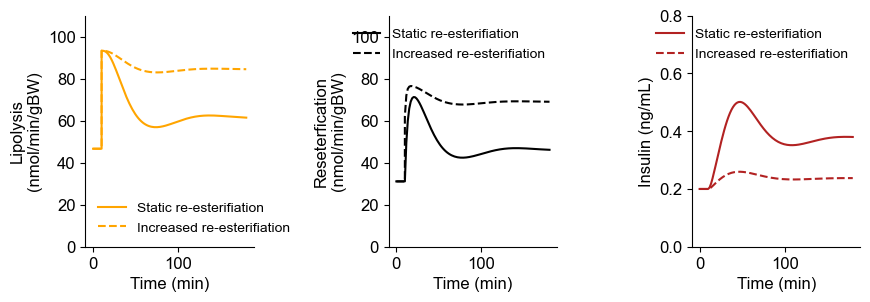

In [44]:
# Make 2 rows 3 columns plot
f, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True)


# Increease the margin between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.8)
# Lipolysis
sns.lineplot(data=F, x='time', y='vA', ax=ax[0], color='orange', label='Static re-esterifiation')
sns.lineplot(data=F_h, x='time', y='vA', ax=ax[0], color='orange', label='Increased re-esterifiation', linestyle='--')
ax[0].set_ylabel('Lipolysis\n(nmol/min/gBW)')
ax[0].set_xlabel('Time (min)')
# ylimt
ax[0].set_ylim(0, 110)
ax[0].legend(frameon=False, fontsize=10)

# Reseterficiation
sns.lineplot(data=F, x='time', y='vR', ax=ax[1], color='black', label='Static re-esterifiation')
sns.lineplot(data=F_h, x='time', y='vR', ax=ax[1], color='black', label='Increased re-esterifiation', linestyle='--')
ax[1].set_ylabel('Reseterfication\n(nmol/min/gBW)')
ax[1].set_ylim(0, 110)
ax[1].set_xlabel('Time (min)')
# Add legend
ax[1].legend(frameon=False, fontsize=10)


# Insulin 
sns.lineplot(data=X, x='time', y='I', ax=ax[2], color='firebrick', label='Static re-esterifiation')
sns.lineplot(data=X_h, x='time', y='I', ax=ax[2], color='firebrick', label='Increased re-esterifiation', linestyle='--')

ax[2].set_ylim(0, 0.8)

ax[2].set_ylabel('Insulin (ng/mL)')
ax[2].set_xlabel('Time (min)')

# Add legend
ax[2].legend(frameon=False, fontsize=10)
# Set the x axis limits

sns.despine()

plt.savefig('output/obesety_dynamics_hyperplasia.svg', bbox_inches='tight')

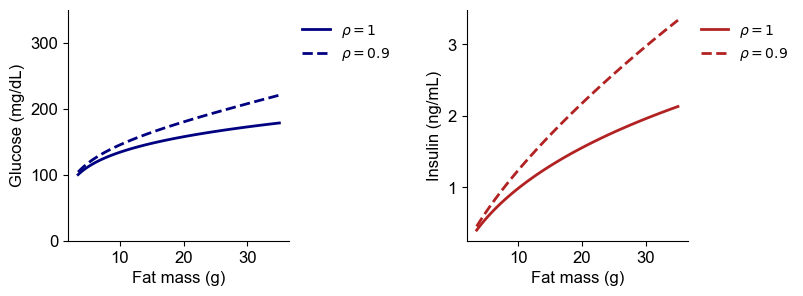

In [ ]:
# Leaky lypolyis  
from minimal_model import change_parameters

# Get steady state of Insulin and Glucose for increased adipose 
from adjustText import adjust_text

A = np.linspace(1, 10, 100)

results = [perturbation_steady_state(a, p=p_fited) for a in A]

p_leaky = p_fited.copy()
p_leaky = change_parameters(p_leaky, e=[0.9,], ix=['rho'])
results_leaky = [perturbation_steady_state(a, p=p_leaky) for a in A]

# Main Figure insulin and glucose
G = [r[1] for r in results]
I = [r[-1] for r in results]

G_leaky = [r[1] for r in results_leaky]
I_leaky = [r[-1] for r in results_leaky]


# Plot 
f, ax = plt.subplots(1, 2, figsize=(8, 3))
# Increase marign between subplots
plt.subplots_adjust(wspace=0.8)

# Glucose scaled to reference of 100
ax[0].plot(A * 3.5 , np.array(G)* 100, color='navy', label=r'$\rho = 1$', linewidth=2)
ax[0].plot(A * 3.5 , np.array(G_leaky)* 100, color='navy', label=r'$\rho = 0.9$', linewidth=2, linestyle='--')

ax[0].set_ylabel('Glucose (mg/dL)')
ax[0].set_xlabel('Fat mass (g)')
ax[0].set_ylim(0, 350)

# Add legend outside of the plot
ax[0].legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Insulin scaled to reference of ng/mL
ax[1].plot(A * 3.5 , np.array(I)/I0 * 0.4 , color='firebrick', label=r'$\rho = 1$', linewidth=2)
ax[1].plot(A * 3.5 , np.array(I_leaky)/I0 * 0.4, color='firebrick', label=r'$\rho = 0.9$', linewidth=2, linestyle='--')

ax[1].set_ylabel('Insulin (ng/mL)')
ax[1].set_xlabel('Fat mass (g)')

# Add legend outside of the plot
ax[1].legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()




